# **MNIST Classifier**

References: 
- https://www.digitalocean.com/community/tutorials/writing-lenet5-from-scratch-in-python
- https://www.kaggle.com/code/shravankumar147/lenet-pytorch-implementation
- https://github.com/lychengrex/LeNet-5-Implementation-Using-Pytorch/blob/master/LeNet-5%20Implementation%20Using%20Pytorch.ipynb

## **Imports**

In [1]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **Dataset**

In [2]:
# Define relevant variables for the ML task
batch_size = 64

#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(
    root="MNIST_original",
    train=True,
    transform=transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
    download=True
)
train_dataset, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

test_dataset = torchvision.datasets.MNIST(
    root="MNIST_original",
    train=False,
    transform=transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
    download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True
)

## **Architecture**

In [ ]:
# LeNet-5
class CNN_Classifier(nn.Module):
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        self.conv = nn.Sequential(
            # conv 1
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # conv 2
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # convert to a feature vector
            nn.Flatten()
        )
        self.head = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    
    def extract_features(self, x):
        return self.conv(x)


    def forward(self, x):
        features = self.conv(x)
        predictions = self.head(features)
        return predictions

## **Train**

In [4]:
learning_rate = 0.001
num_epochs = 10

model = CNN_Classifier().to(device)
    
# Setting the loss function
loss_fn = nn.CrossEntropyLoss()

# Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

[1/10][50/782] Loss: 0.5905, Batch Acc: 84.375, Val Acc: 78.22
[1/10][100/782] Loss: 0.2549, Batch Acc: 90.625, Val Acc: 90.14
[1/10][150/782] Loss: 0.2355, Batch Acc: 93.75, Val Acc: 91.89
[1/10][200/782] Loss: 0.1068, Batch Acc: 96.875, Val Acc: 93.74
[1/10][250/782] Loss: 0.1120, Batch Acc: 96.875, Val Acc: 95.4
[1/10][300/782] Loss: 0.0861, Batch Acc: 98.4375, Val Acc: 95.79
[1/10][350/782] Loss: 0.0970, Batch Acc: 96.875, Val Acc: 96.39
[1/10][400/782] Loss: 0.1165, Batch Acc: 96.875, Val Acc: 96.77
[1/10][450/782] Loss: 0.2154, Batch Acc: 92.1875, Val Acc: 96.47
[1/10][500/782] Loss: 0.0839, Batch Acc: 95.3125, Val Acc: 96.31
[1/10][550/782] Loss: 0.1115, Batch Acc: 95.3125, Val Acc: 96.45
[1/10][600/782] Loss: 0.1273, Batch Acc: 96.875, Val Acc: 97.19
[1/10][650/782] Loss: 0.1026, Batch Acc: 95.3125, Val Acc: 97.12
[1/10][700/782] Loss: 0.0663, Batch Acc: 98.4375, Val Acc: 97.55
[1/10][750/782] Loss: 0.0176, Batch Acc: 100.0, Val Acc: 97.64
[2/10][50/782] Loss: 0.0510, Batch Acc

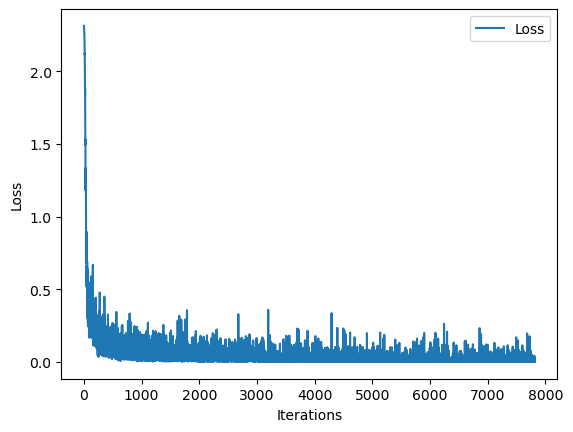

In [5]:
losses = []
accs = []
val_accs = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        losses.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        acc = 100 * correct / total
        accs.append(acc)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        eval_correct = 0
        eval_total = 0
        for j, (eval_images, eval_labels) in enumerate(val_loader):
            eval_images = eval_images.to(device)
            eval_labels = eval_labels.to(device)
            outputs = model.forward(eval_images)
            _, predicted = torch.max(outputs.data, 1)
            eval_total += eval_labels.size(0)
            eval_correct += (predicted == eval_labels).sum().item()
        val_acc = 100 * eval_correct / eval_total
        val_accs.append(val_acc)

        if (i+1) % 50 == 0:
            print ('[{}/{}][{}/{}] Loss: {:.4f}, Batch Acc: {}, Val Acc: {}'
                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item(), acc, val_acc))
            
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.save(model.state_dict(), f"classifier/mnist_classifier.pth")

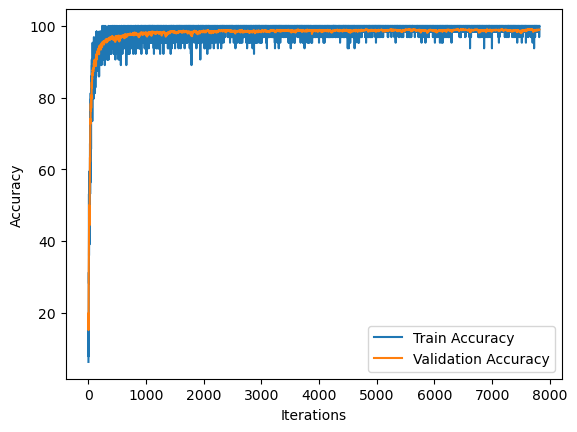

In [6]:
plt.plot(accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## **Test**

In [7]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model.forward(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 99.01 %
